# CIS4930 : Student Depression Prediction
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

## Data Exploration

In [2]:
depression_df = pd.read_csv('student_depression_prediction.csv')
display(depression_df.head())
display(depression_df.tail())

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,No,1
27900,140699,Male,27.0,Patna,Student,4.0,0.0,9.24,1.0,0.0,Less than 5 hours,Healthy,BCA,Yes,2.0,3.0,Yes,1


In [3]:
display(depression_df.info())
display(depression_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

None

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27898.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,3.139867,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,1.437347,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,2.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,3.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,4.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,5.000000,1.000000


In [4]:
# Check for missing values
null_entries = depression_df.isnull().sum()
print("Number of Nan:")
display(null_entries)

# Check for duplicates
num_duplicates = depression_df.duplicated().sum() # Sums duplicated entries
print("Number of duplicate values: ", num_duplicates)

Number of Nan:


id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         3
Family History of Mental Illness         0
Depression                               0
dtype: int64

Number of duplicate values:  0


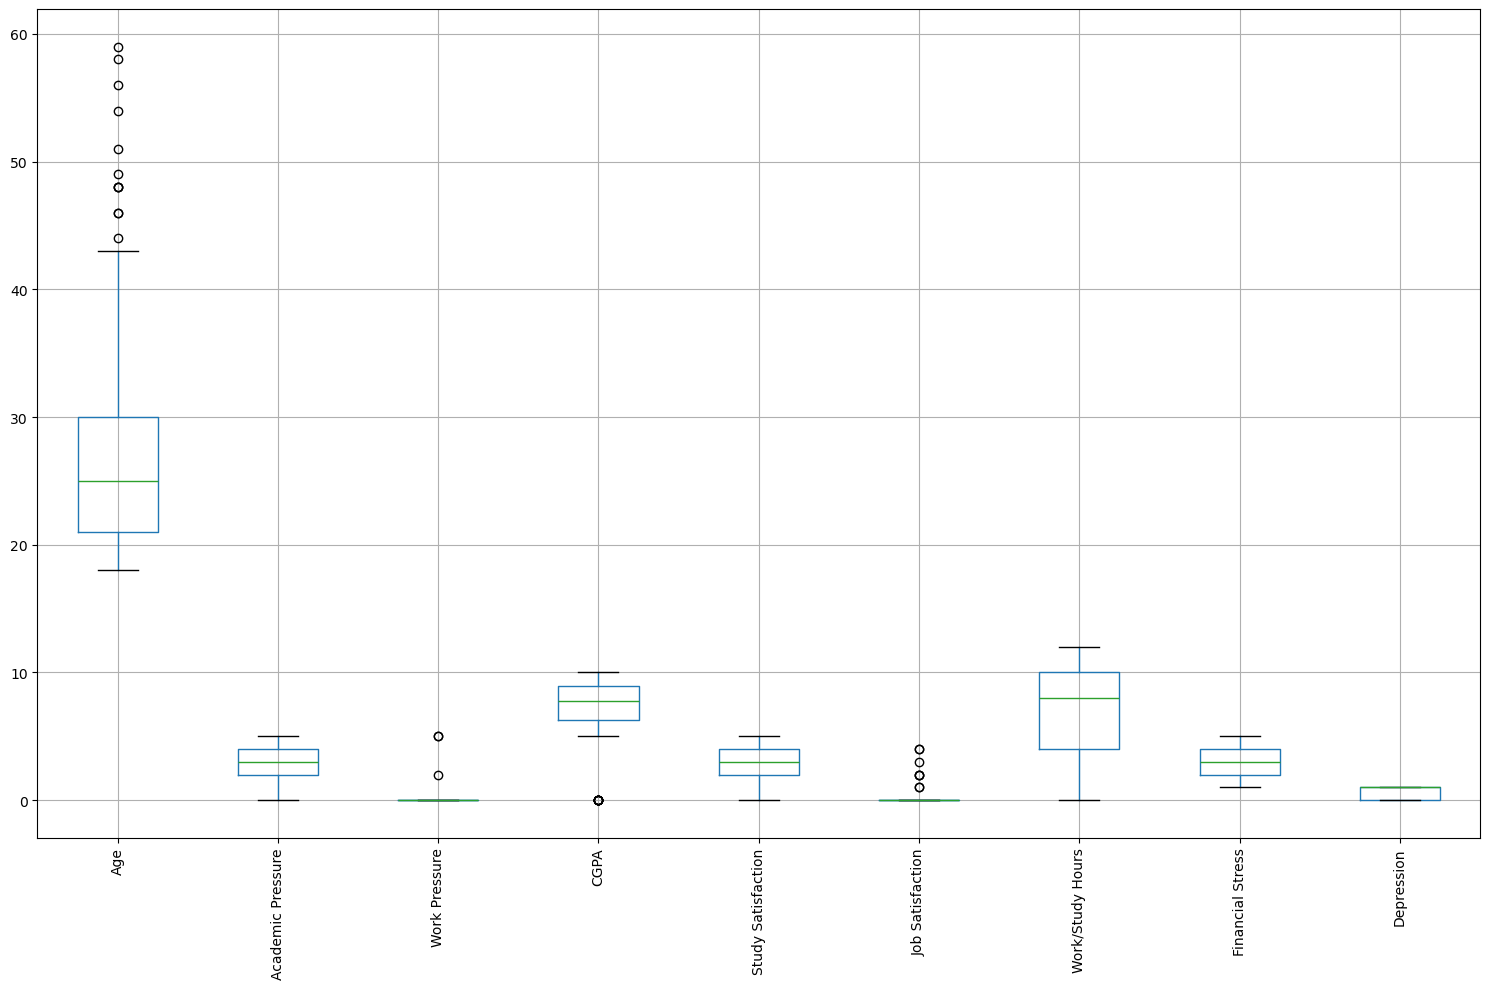

In [5]:
plt.figure(figsize=(15, 10))
depression_df.drop(["id"], axis=1).boxplot()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

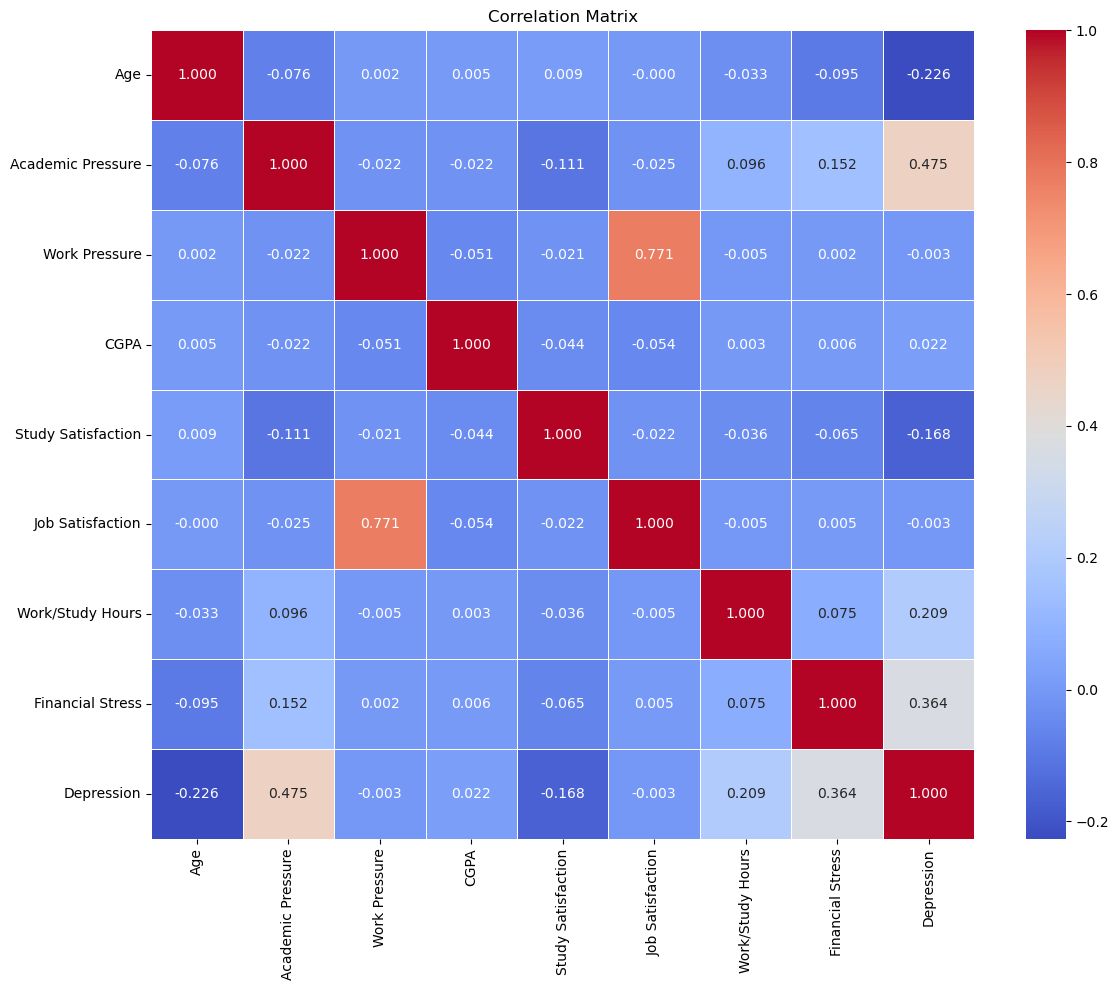

In [6]:
numerical_df = depression_df.select_dtypes(include=[np.number]).drop(columns=['id'], axis=1)

plt.figure(figsize=(12, 10))
correlation = numerical_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".3f")
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

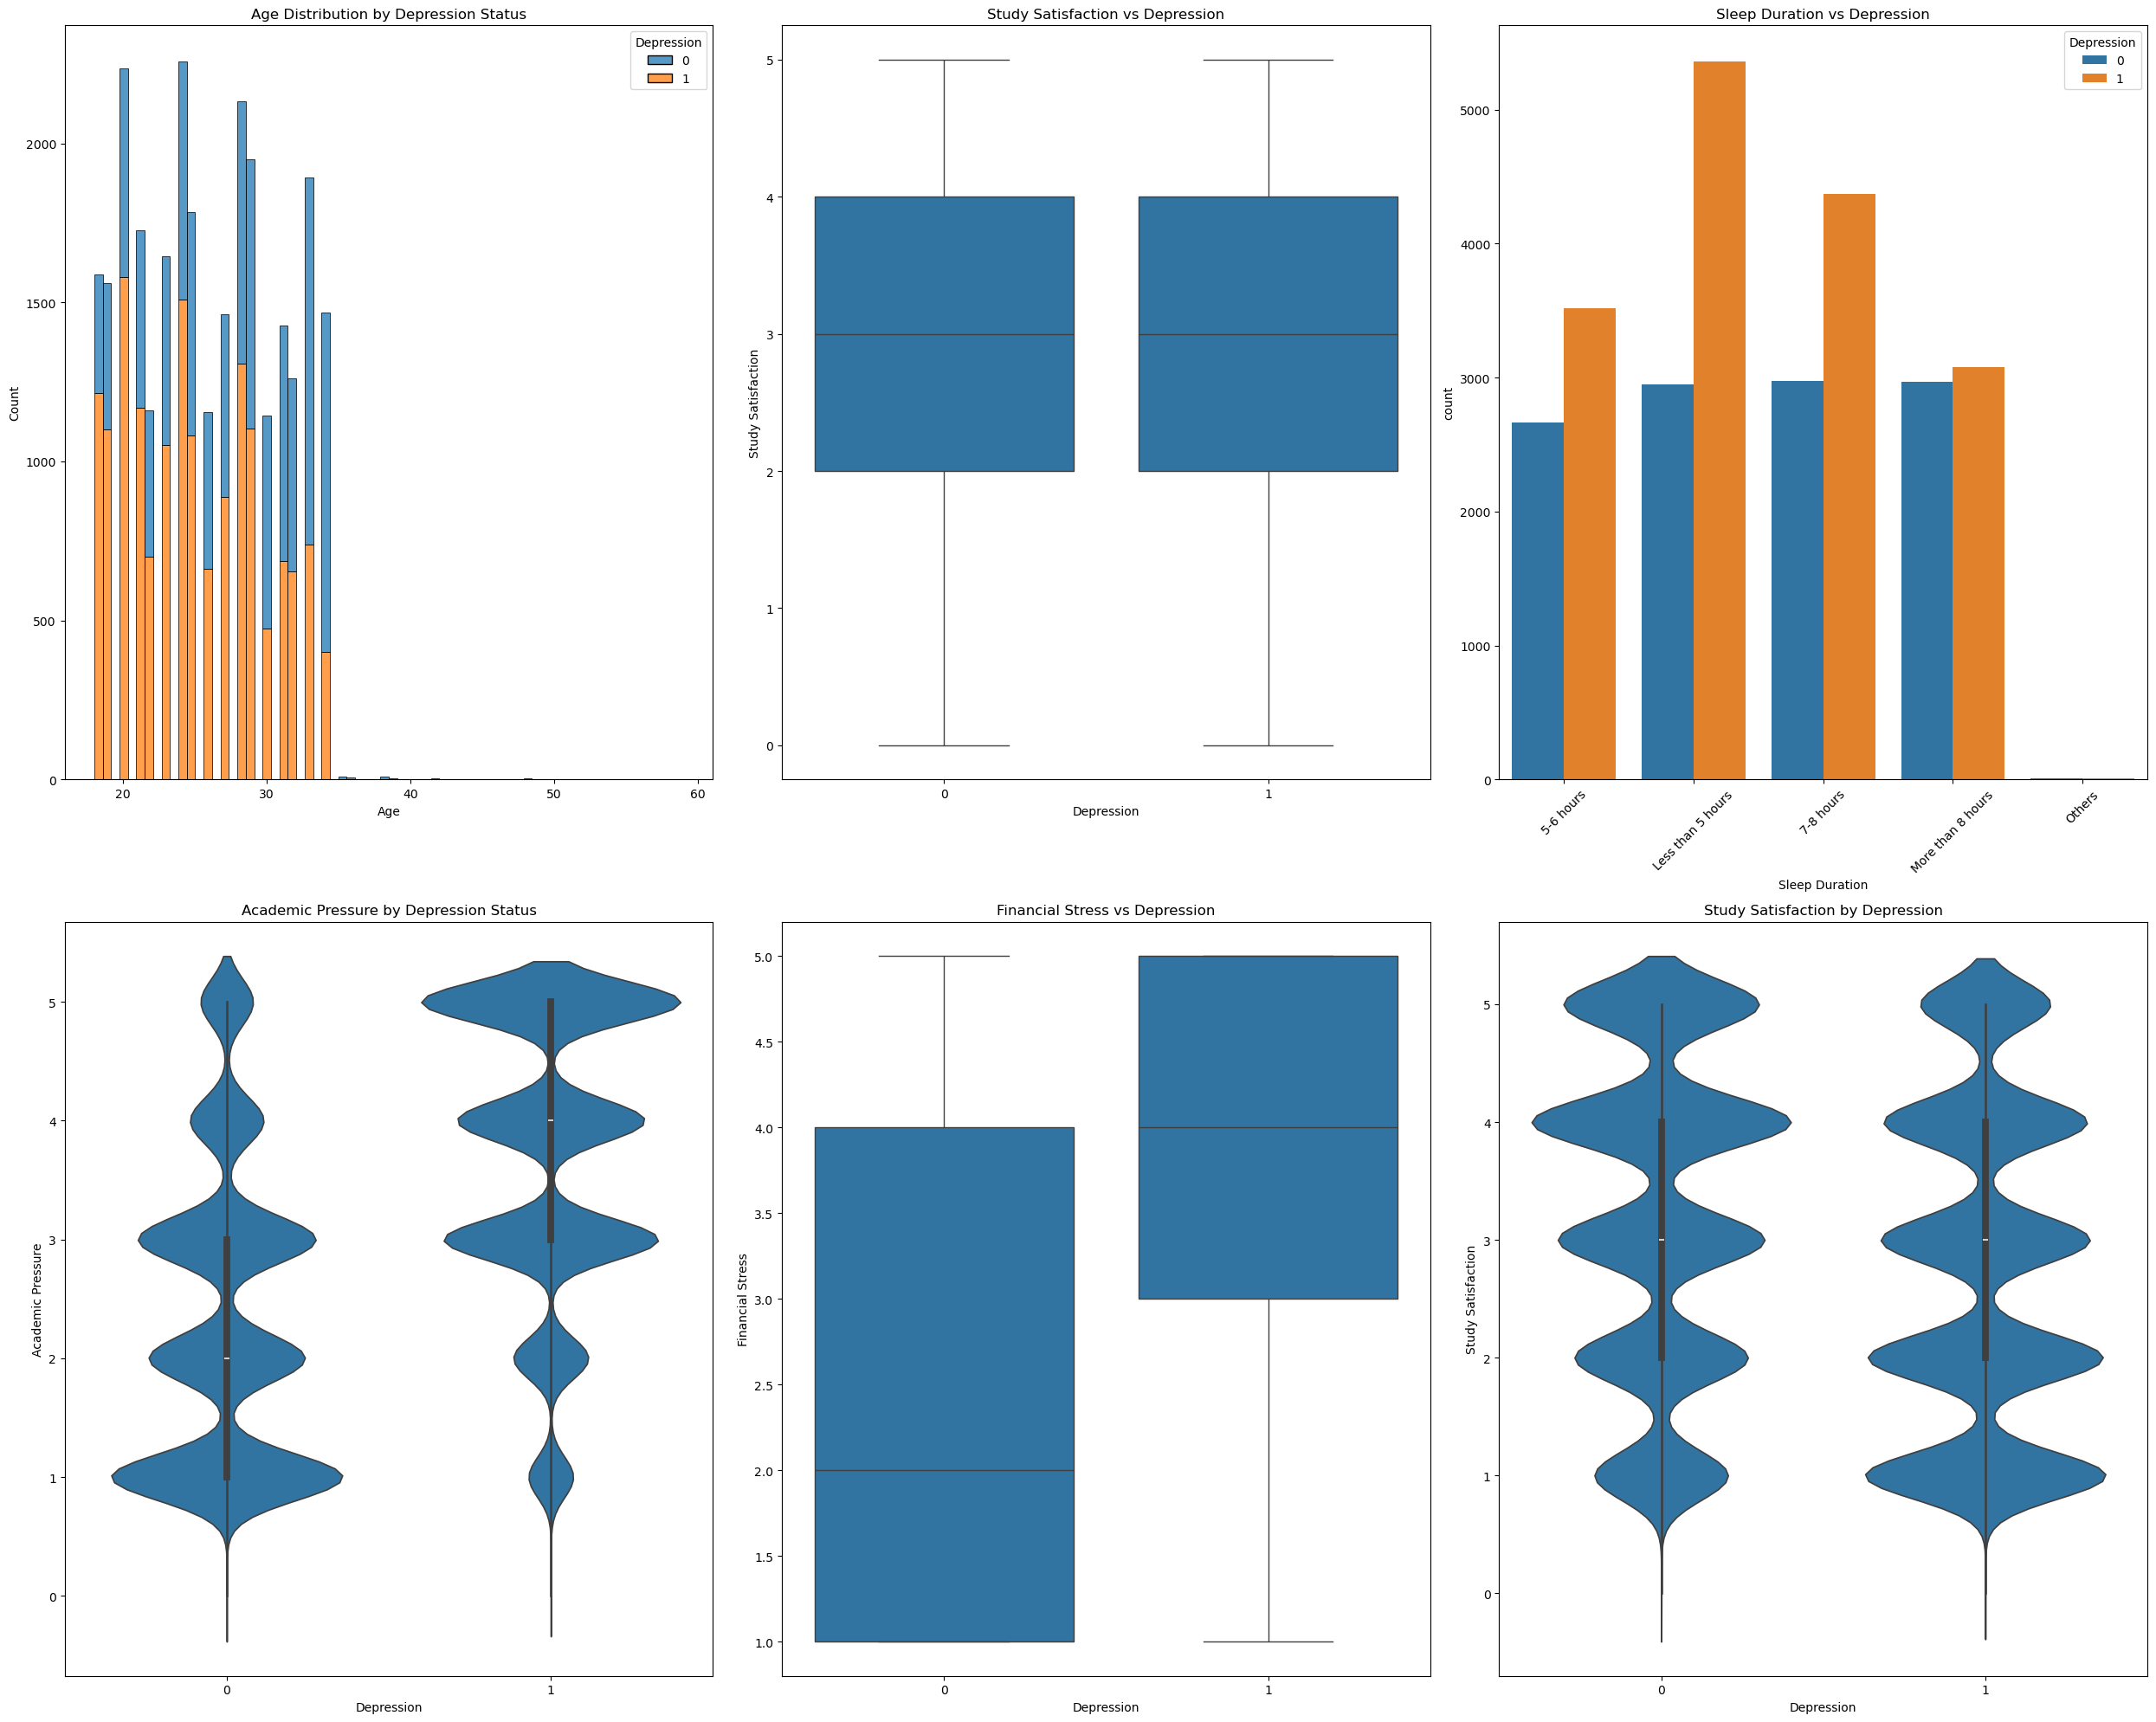

In [7]:
# Create 6 different plots to explore the data
fig, axes = plt.subplots(2, 3, figsize=(25, 20))

# 1. Distribution of age by depression status
sns.histplot(data=depression_df, x='Age', hue='Depression', multiple='stack', ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution by Depression Status')

# 2. Relationship between Study Satisfaction and Depression
sns.boxplot(data=depression_df, x='Depression', y='Study Satisfaction', ax=axes[0, 1])
axes[0, 1].set_title('Study Satisfaction vs Depression')

# 3. Sleep Duration vs Depression
sns.countplot(data=depression_df, x='Sleep Duration', hue='Depression', ax=axes[0, 2])
axes[0, 2].set_title('Sleep Duration vs Depression')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Academic Pressure by Depression Status
sns.violinplot(data=depression_df, x='Depression', y='Academic Pressure', ax=axes[1, 0])
axes[1, 0].set_title('Academic Pressure by Depression Status')

# 5. Financial Stress vs Depression
sns.boxplot(data=depression_df, x='Depression', y='Financial Stress', ax=axes[1, 1])
axes[1, 1].set_title('Financial Stress vs Depression')

# 6. Depression rate by Gender and Family History
# 4. Academic Pressure by Depression Status
sns.violinplot(data=depression_df, x='Depression', y='Study Satisfaction', ax=axes[1, 2])
axes[1, 2].set_title('Study Satisfaction by Depression')
plt.tight_layout()
plt.show()

## Cleaning and Processing Data

In [8]:
df = depression_df.copy()

# Drop nulls and duplicates
df = df.dropna()
df = df.drop_duplicates()

# Drop work pressure column for multicollinearity
df = df.drop(columns=['Work Pressure'], axis=1)

# Targeting Age, Work Pressure, CGPA, and Job Satisfaction for outliers
target_cols = ['Age', 'CGPA', 'Job Satisfaction']
original_len = len(df)

for col in target_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Filter out outliers
  df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Show how many rows were removed
removed_rows = original_len - len(df)
print(f"Original dataset size: {original_len}")
print(f"Cleaned dataset size: {len(df)}")
print(f"Removed {removed_rows} rows")

Original dataset size: 27898
Cleaned dataset size: 27875
Removed 23 rows


In [9]:
categorical_columns = ['Gender', 'City', 'Profession', 'Sleep Duration', 'Dietary Habits', 'Degree', 'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
for column in categorical_columns:
    df[column] = LabelEncoder().fit_transform(df[column])

X = df.drop(['id', 'Depression'], axis=1)
y = df['Depression']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
# View if there is class imbalance
class_counts = y.value_counts().to_frame()
class_counts.index = ["Positive", "Negative"]
display(class_counts)

,count
Positive,16328
Negative,11547


In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=16)

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((22300, 15), (5575, 15), (22300,), (5575,))

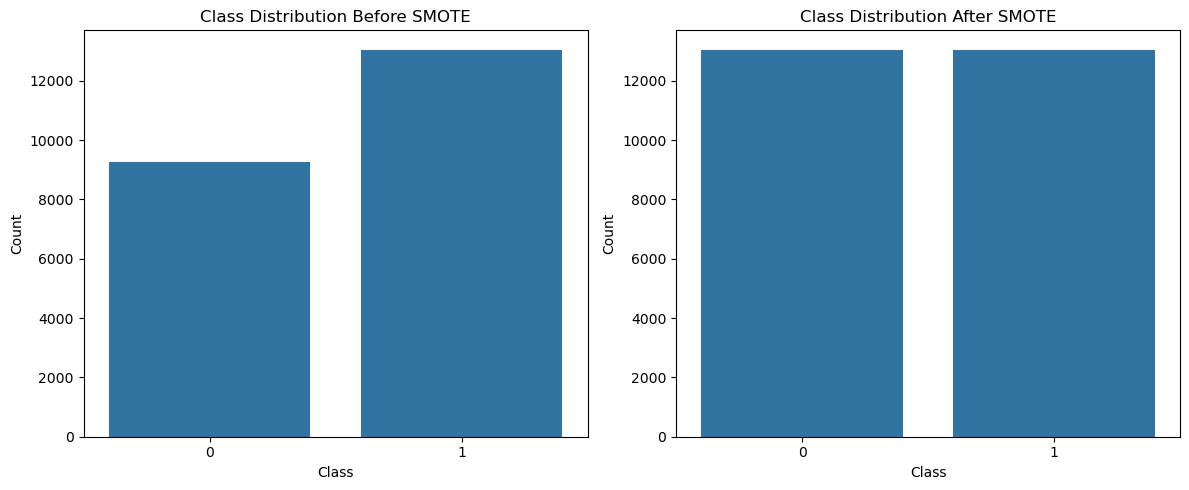

Before SMOTE: Depression
1    13049
0     9251
Name: count, dtype: int64
After SMOTE: Depression
1    13049
0    13049
Name: count, dtype: int64


In [12]:
# Apply SMOTE to the training data only
smote = SMOTE(random_state=16)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Visualize class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("Class Distribution Before SMOTE")
axes[0].set_xlabel("Class")
axes[0].set_ylabel("Count")

# After SMOTE
sns.countplot(x=y_train_resampled, ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE")
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Print the new class distribution
print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts())

## Machine Learning Models

In [13]:
def evaluate_model(model, name, X, y):
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1 Score: ", f1)
    print()

    cm = confusion_matrix(y, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0.5, 1.5], ["No Depression", "Depression"])
    plt.yticks([0.5, 1.5], ["Depression", "Depression"])
    plt.show()

    return (accuracy, precision, recall, f1)

### Logistic Regression

Accuracy:  0.8342600896860987
Precision:  0.8713339640491958
Recall:  0.8426349496797805
F1 Score:  0.8567441860465116



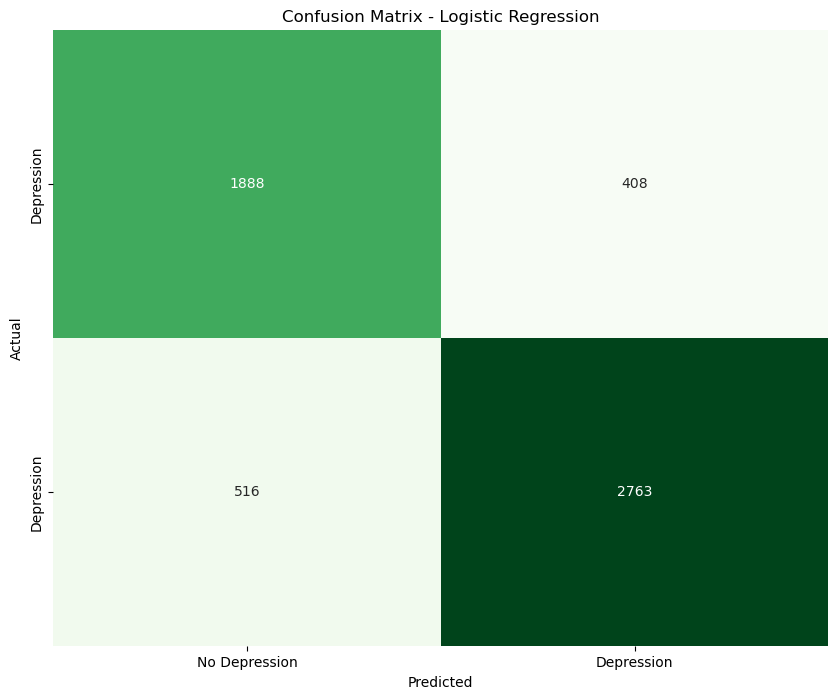

In [14]:
logistic_model = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, random_state=16)
logistic_model.fit(X_train_resampled, y_train_resampled)
logistic_result = evaluate_model(logistic_model, "Logistic Regression", X_test, y_test)

### KNN

In [21]:
parameter_values = {"n_neighbors": list(range(1, 20, 2)),
                    "weights": ["uniform", "distance"],
                    "p": [1, 1.5, 2], "n_jobs": [5]
                   }
gs_knn = KNeighborsClassifier()
gs = GridSearchCV(gs_knn, parameter_values, scoring="f1", n_jobs=-1)
gs.fit(X_train_resampled, y_train_resampled)

print("Best parameters: ", gs.best_params_)

knn_model = KNeighborsClassifier(**gs.best_params_)
knn_model.fit(X_train_resampled, y_train_resampled)
knn_result = evaluate_model(knn_model, "KNN", X_test, y_test)

KeyboardInterrupt: 

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train and evaluate a Decision Tree model
dt_model = DecisionTreeClassifier(    
    class_weight='balanced',
    criterion='entropy',
    max_depth=10,
    max_leaf_nodes=None,
    min_samples_leaf=2,
    min_samples_split=2,
    random_state=1217
    )
dt_model.fit(X_train_resampled, y_train_resampled)
print("Decision Tree Model Evaluation:")
evaluate_model(dt_model, "Decision Tree", X_test, y_test)

Best parameters found: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validated F1 score: 0.8431112312852272


### Random Forest

Random Forest Model Evaluation:
Accuracy:  0.8340807174887892
Precision:  0.8590604026845637
Recall:  0.8587984141506557
F1 Score:  0.8589293884398352



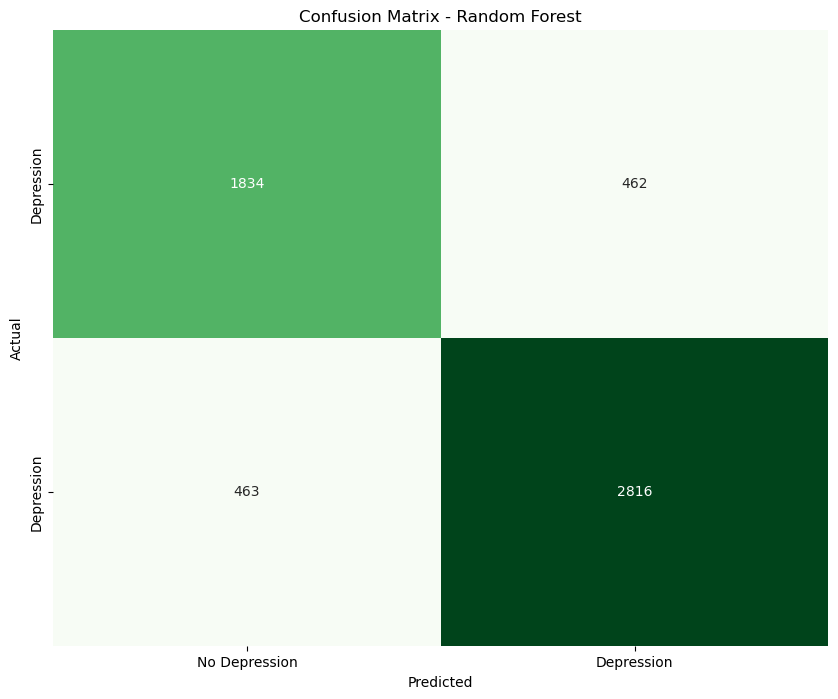

(0.8340807174887892,
 0.8590604026845637,
 0.8587984141506557,
 0.8589293884398352)

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Train and evaluate a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=1217)
rf_model.fit(X_train_resampled, y_train_resampled)
print("Random Forest Model Evaluation:")
evaluate_model(rf_model, "Random Forest", X_test, y_test)

### SVM

SVM Model Evaluation:
Accuracy:  0.8333632286995516
Precision:  0.8704287515762925
Recall:  0.8420250076242757
F1 Score:  0.8559913191753217



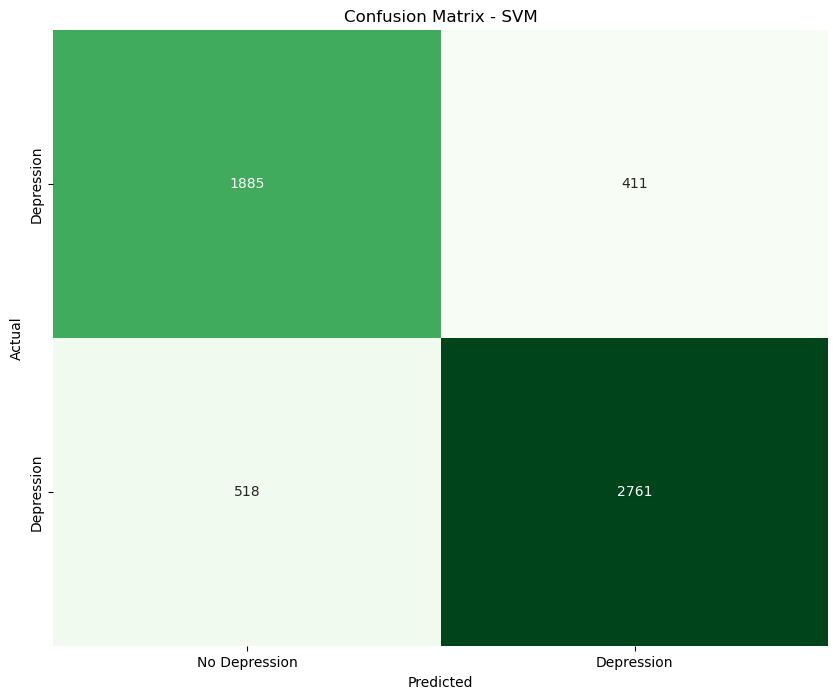

(0.8333632286995516,
 0.8704287515762925,
 0.8420250076242757,
 0.8559913191753217)

In [ ]:
from sklearn.svm import SVC

# Train and evaluate a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear', random_state=1217)
svm_model.fit(X_train_resampled, y_train_resampled)
print("SVM Model Evaluation:")
evaluate_model(svm_model, "SVM", X_test, y_test)